# Introduction


**Goal of the Competition**

The goal of this competition is to accurately identify starfish in real-time by building an object detection model trained on underwater videos of coral reefs.

Your work will help researchers identify species that are threatening Australia's Great Barrier Reef and take well-informed action to protect the reef for future generations.

**Context**

Australia's stunningly beautiful Great Barrier Reef is the world’s largest coral reef and home to 1,500 species of fish, 400 species of corals, 130 species of sharks, rays, and a massive variety of other sea life.

Unfortunately, the reef is under threat, in part because of the overpopulation of one particular starfish – the coral-eating crown-of-thorns starfish (or COTS for short). Scientists, tourism operators and reef managers established a large-scale intervention program to control COTS outbreaks to ecologically sustainable levels.

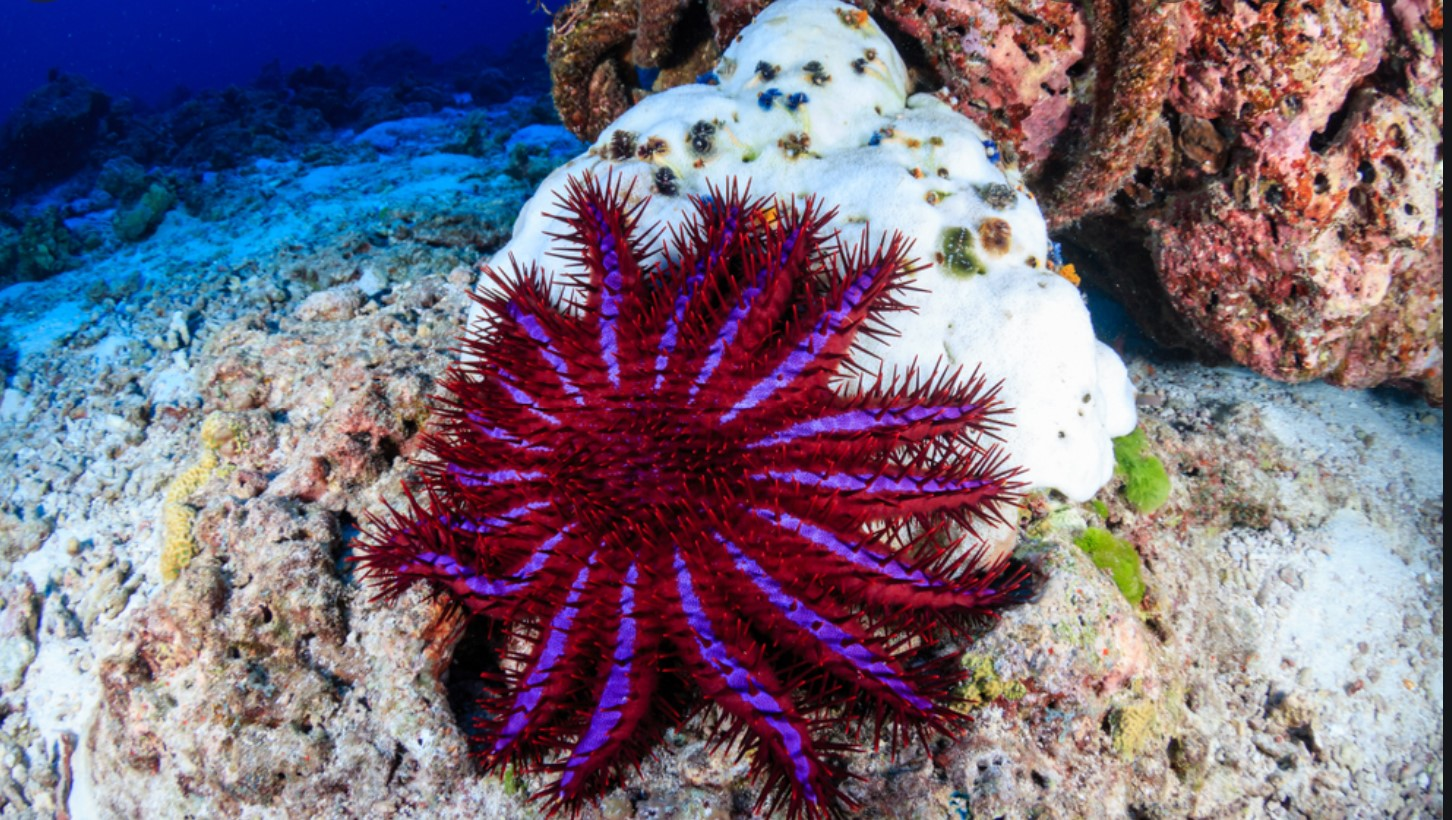
pic credits(2018 Richard Whitcombe/Shutterstock @LiesurePro)

They occur naturally on reefs throughout the Indo-Pacific region, and when conditions are right, they can reach plague proportions and devastate hard coral communities. These crown-of-thorns starfish are a major cause of coral loss on the Great Barrier Reef, after coral bleaching.

# Why this notebook?


1. For running inference using yolov5 models.
2. For visualization of tracking with ground truth annotation bounding boxes.
3. I have also included scripts for implementing your own fold csv to test on your own test dataset.
4. I have also incorporated script to calculate F2 score. (Original implementation Camaro)

# Notebook Reference


1. Remek Kinas' work on yolo, there are soo many notebooks he has provided. It was a great learning experience from his notebooks.
2. ALEKSANDR SNORKIN's work for tracking implememtation here https://www.kaggle.com/parapapapam/yolox-inference-tracking-on-cots-lb-0-539
3. F2 score calculation by Camaro https://www.kaggle.com/bamps53/competition-metric-implementation
3. The beautiful and amazing kaggle discussion community.

**I really request everyone to please upvote above works, I got to learn a lot from them.**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        s='empty'
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Initialization

**Imports and setting up helpers.**

In [ ]:
import os
import pandas as pd
import glob
import cv2
import PIL
import matplotlib.pyplot as plt
import xml.etree.cElementTree as ET
import ast
from tqdm import tqdm


import argparse
import multiprocessing
import os
import sys

import cv2
import numpy
import tensorflow as tf

import tensorflow_addons as tfa


import os
import numpy
import tensorflow as tf
from tensorflow.keras import utils
import xml

#os.chdir('../')

# Helper

In [ ]:


from  copy import copy

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes
def get_path(row):
    row['image_path'] = f'{TRAIN_PATH}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row
#f'./working/data_dir/COTS_UNANNOTATED/images/{row.image_id}.jpg')

def get_path_preprocessed(row):
    row['image_path_preprocessed'] = f'{TRAIN_PATH_PREPROCESSED}/images_preprocessed/video_{row.video_id}_{row.video_frame}.jpg'
    return row
def get_unannotated_path(row):
    row['image_path_unannotated'] = f'{UNANNOTATED_PATH}/images_preprocessed/{row.image_id}.jpg'
    return row

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)



def yolo2voc(bboxes, image_height=720, image_width=1280):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2yolo(bboxes, image_height=720, image_width=1280):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    #print(bboxes)
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def voc2coco(bboxes, image_height=720, image_width=1280):
    bboxes  = voc2yolo(bboxes, image_height, image_width)
    #print('VOC2COCO', bboxes)
    bboxes  = yolo2coco( image_height, image_width, bboxes)
    return bboxes




def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [0, 0, 255], thickness=tf, lineType=cv2.LINE_AA)



def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            #print(cls,class_ids )
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def create_annot(bboxes, bbox_format = 'yolo'):
    annotation=''
    if bbox_format == 'yolo':
        for index,bbox in enumerate(bboxes):
            annot= ('0 '+ ' '.join([str(el) for el in bbox])).strip() +'\n'
            annotation= annotation+annot
            #print(annot)
            #break
    return annotation




#      class x_center y_center width height  

np.random.seed(8)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
colors=(255,0,0)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

In [ ]:
#Changing to ./kaggle
%cd ../

**Importing csv training and test**

In [ ]:
train_csv= pd.read_csv('./input/tensorflow-great-barrier-reef/train.csv')
test_csv= pd.read_csv('./input/tensorflow-great-barrier-reef/test.csv')

In [ ]:
#visualization of sample.
train_csv.sample(4)

In [ ]:
#Loading path of all the images
images= glob.glob("./input/tensorflow-great-barrier-reef/train_images/*/*.jpg")

In [ ]:
train_csv["NumOfBBox"]=train_csv['annotations'].apply(lambda x: str.count(x, 'x'))
train_csv.head(5)

In [ ]:
#Thus we see a lot of images with no bboxes.
#We will try to have 1% of such background images in dataset as recommended by ultralytics
print(train_csv["NumOfBBox"].value_counts())

In [ ]:
#Separating cases with 0 bboxes.
df_train_csv=train_csv[train_csv["NumOfBBox"]>0]
df_train_csv.sample(2)

In [ ]:
df_train_csv['annotations'] = df_train_csv['annotations'].apply(lambda x: ast.literal_eval(str(x))) #(lambda x: ast.literal_eval(x))
df_train_csv['bboxes'] = df_train_csv.annotations.apply(get_bbox)

In [ ]:
df_train_csv["Width"]=1280
df_train_csv["Height"]=720

In [ ]:
TRAIN_PATH= './input/tensorflow-great-barrier-reef/'
TRAIN_PATH_PREPROCESSED= './working/data_dir/yolo/' #If you want to add some preprocessed images.

In [ ]:
df_train_csv = df_train_csv.apply(get_path, axis=1)
df_train_csv = df_train_csv.apply(get_path_preprocessed, axis=1)
df_train_csv.sample(2)

In [ ]:
df_v = df_train_csv[(df_train_csv.NumOfBBox==13)].sample(2) 
fig,ax = plt.subplots(1,2,figsize=(30,20))
i=0;
for index, row in df_v.iterrows():
    img           = load_image(row.image_path) # Change to image_path_preprocessed if you want results on preprocessed images
    image_height  = row.Height
    image_width   = row.Width
    bboxes_coco   = np.array(row.bboxes)
    bboxes_yolo   = coco2yolo(image_height, image_width, bboxes_coco)
    names         = ['COTS']*len(bboxes_coco)
    labels        = [0]*len(bboxes_coco)
    im=draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2)
    ax[i].imshow(im)
    ax[i].axis('OFF')
    i=i+1

# Data folds and preprocessings

**Fold can be skipped if you are loading your own csv of fold**

In [ ]:
'''from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5) 
df_train_csv = df_train_csv.reset_index(drop=True)
df_train_csv['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train_csv, y = df_train_csv.video_id.tolist(), groups=df_train_csv.sequence)):
    df_train_csv.loc[val_idx, 'fold'] = fold
display(df_train_csv.fold.value_counts())'''

In [ ]:
selected=4

In [ ]:
train_5_folds_csv= pd.read_csv('./input/reef-cv-strategy-subsequences-dataframes/cross-validation/train-10folds.csv')
train_5_folds_csv.sample(2)

**We will now merge the dataset with folds from csv**

In [ ]:
dfinal = train_5_folds_csv.merge(df_train_csv, on="image_id", how = 'inner')
dfinal.sample(2)

# Yolov5 starter.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
import sys
#sys.path.append('./input/tensorflow-great-barrier-reef')
import torch
from PIL import Image
import ast
import tensorflow_addons as tfa

In [ ]:
#To adjust the image size
IMG_SIZE=3600

In [ ]:
#Model set checkpoint
Best_Model = './input/v5l6-unprocessed-3648-v1/best.pt'

In [ ]:
def load_model(Best_Model, conf=0.25, iou=0.30):
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = torch.hub.load('./input/yolov5/yolov5-master/',
                           'custom',
                           path=Best_Model,
                           source='local',
                           force_reload=True)  # local repo
    model.conf = conf  # NMS confidence threshold
    model.iou  = iou  # NMS IoU threshold
    model.classes = None   # (optional list) filter by class, i.e. = [0, 15, 16] for persons, cats and dogs
    model.multi_label = False  # NMS multiple labels per box
    model.max_det = 1000  # maximum number of detections per image
    return model



def predict(model, img, size=1280, augment=False,equalize= True):
    if equalize:
        img= tfa.image.equalize(img)
        img= img.numpy()
    height, width = img.shape[:2]
    #print(img.shape,height,width)
    results = model(img, size=size, augment=augment)  # custom inference size
    #print(type(results))
    preds   = results.pandas().xyxy[0]
    
    bboxes  = preds[['xmin','ymin','xmax','ymax']].values
    if len(bboxes):
        #print(bboxes)
        bboxes_voc= bboxes
        bboxes  = voc2coco(bboxes,height,width).astype(int)
        bboxes_with_conf= []
        bboxes_tracking= []
        #print(bboxes)
        confs   = preds.confidence.values
        #print(confs)
        for index,conf in enumerate(confs):
            #print(conf)
            bboxes_with_conf.append(np.insert(bboxes[index].astype(float), 0, float(conf), axis=0).tolist())
            bboxes_tracking.append(np.insert(bboxes_voc[index].astype(float), 4, float(conf), axis=0).tolist())

            #bboxes_with_conf.insert(0, conf)
            #bboxes[index]
        #print(bboxes_with_conf)
        return bboxes, confs,bboxes_with_conf,bboxes_tracking
    else:
        return [],[],[],[]
    
def format_prediction(bboxes, confs):
    annot = ''
    if len(bboxes)>0:
        for idx in range(len(bboxes)):
            xmin, ymin, w, h = bboxes[idx]
            conf             = confs[idx]
            annot += f'{conf} {xmin} {ymin} {w} {h}'
            annot +=' '
        annot = annot.strip(' ')
    return annot

def show_img(img, bboxes, bbox_format='yolo'):
    names  = ['starfish']*len(bboxes)
    labels = [0]*len(bboxes)
    img    = draw_bboxes(img = img,
                           bboxes = bboxes, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = bbox_format,
                           line_thickness = 2)
    return Image.fromarray(img).resize((800, 400))

In [ ]:
# Copying Arial file
os.mkdir('../root/.config/Ultralytics/')
!cp ./input/arial-ds/Arial.ttf ../root/.config/Ultralytics/

In [ ]:
#Loading the model
CONF= 0.36
IOU= 0.40
model = load_model(Best_Model, conf=CONF, iou=IOU)

In [ ]:
# WE ONLY CHECK fourth fold as that is used for validation.
annotations_predicted= []
annotations_original= []
annotations_predicted_coco= []
annotations_original_coco= []
bboxes_trackings= []

confidences=[]
visualization_images= []
for i in tqdm(range(len(dfinal))):
    row= dfinal.iloc[i]
    if row.fold != 4:
        continue
    bboxes_original= row.bboxes
    image_path = row.image_path_y
    img = cv2.imread(image_path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img= tfa.image.equalize(img)
    #img= img.numpy()[...,::-1]
    names = ['COTS']*len(bboxes_coco)
    
    bboxes, confs,bboxes_with_conf,bboxes_tracking= predict(model, img, size=IMG_SIZE, augment=True) #VOC2COCO
    bboxes_yolo = []
    bboxes_trackings.append(bboxes_tracking)
    bboxes_voc = []
    bboxes_original_yolo= coco2yolo(image_height, image_width, np.array(bboxes_original))
    bboxes_original_voc= yolo2voc(bboxes_original_yolo, image_height=720, image_width=1280)
    if len(bboxes)!=0:
        bboxes_yolo   = coco2yolo(image_height, image_width, np.array(bboxes))
        bboxes_voc   = yolo2voc(bboxes_yolo, image_height=720, image_width=1280)
    
    annotations_predicted_coco.append(np.array(bboxes_with_conf))
    annotations_original_coco.append(np.array(bboxes_original))
    #print(len(bboxes))
    labels = [0]*len(bboxes)
    if len(bboxes)!=0:
        #print('len bboxes ', len(bboxes),names, labels )
        img = draw_bboxes(img = img,
                       bboxes = bboxes_original,
                       classes = [0]*len(bboxes_original),
                       class_ids = [0]*len(bboxes_original),
                       class_name = True,
                       colors = colors,
                       bbox_format = 'coco',
                       line_thickness = 4)

        
        img =draw_bboxes(img = img,
                       bboxes = bboxes_yolo,
                       classes = [0]*len(bboxes_yolo),
                       class_ids = [0]*len(bboxes_yolo),
                       class_name = True,
                       colors = (0,255,0),
                       bbox_format = 'yolo',
                       line_thickness = 2)
    confidences.append(confs)
    annotations_predicted.append(bboxes_yolo)#bboxes_original
    annotations_original.append(bboxes_original_yolo)
    visualization_images.append(img)
    

# Visualization of prediction and ground truth BBoxes

**Defining plotting function**

In [ ]:
#Visualizing some sample batches of the images.
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import animation
#from matplotlib import figure
import matplotlib.pyplot as plt
from IPython.display import HTML
import glob

%matplotlib inline

def plot_images(img_list):
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    fig = plt.figure(figsize=(8,8))
    #fig.tight_layout()
    
    ax = fig.gca()
    #print(img_list)
    plt.axis('off')
    fig.tight_layout(pad=0)
    print("Sample Image and video")
    img = ax.imshow(img_list[0])
    
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(img_list), interval=500, blit=True)
    return anim



**Here Red Bounding box is actual ground truth and Green Bounding box is Yolov5 prediction**

In [ ]:
import warnings
from IPython.display import HTML
import random

warnings.filterwarnings('ignore')
#random.sample(visualization_images, 150)
HTML(plot_images(visualization_images[200:500]).to_html5_video())


# Tracking Setup (Norfair)

**Installing dependancies**

In [ ]:
# norfair dependencies
%cd input/norfairwithdependency/
!pip install commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
!pip install rich-9.13.0-py3-none-any.whl

!mkdir ../../working/tmp
!cp -r filterpy-1.4.5/filterpy-1.4.5/ ../../working/tmp/
%cd ../../working/tmp/filterpy-1.4.5/
!pip install .
!rm -rf ../../working/tmp

#!ls ../../../input
# norfair
%cd ../../../input/norfairwithdependency/
!pip install norfair-0.3.1-py3-none-any.whl -f ./ --no-index

In [ ]:
##############################################################
#                      Tracking helpers                      #
##############################################################

import numpy as np
from norfair import Detection, Tracker

#from input.norfair.norfair-master.norfair.tracker import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

In [ ]:
submission_dict = {
    'id': [],
    'prediction_string': [],
}
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=50,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)


In [ ]:
frame_id = 0

imgs_vis_tracking= []
for index,img_bboxes in enumerate(bboxes_trackings):
    
    predictions = []
    detects = []
    predictions_bboxes= []
    for i in range(len(img_bboxes)):
        score= img_bboxes[i][4]
        if score<CONF:
            continue
        bbox_width = img_bboxes[i][2] - img_bboxes[i][0]
        bbox_height = img_bboxes[i][3] - img_bboxes[i][1]
        predictions.append('{:.2f} {} {} {} {}'.format(score, img_bboxes[i][0],img_bboxes[i][1], bbox_width, bbox_height))
        predictions_bboxes.append(np.array( [img_bboxes[i][0],img_bboxes[i][1], bbox_width, bbox_height]))
        
        
    
    tracked_objects = tracker.update(detections=to_norfair(img_bboxes, frame_id))
    
        
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        predictions_bboxes.append(np.array( [x_min, y_min, bbox_width, bbox_height]))
    #######################################################
    
    #print(predictions)
    prediction_str = ' '.join(predictions)
    
    #sample_prediction_df['annotations'] = prediction_str
    #print(prediction_str)
    #env.predict(sample_prediction_df)
    img = draw_bboxes(img = visualization_images[index],
                       bboxes = predictions_bboxes,
                       classes = [0]*len(predictions_bboxes),
                       class_ids = [0]*len(predictions_bboxes),
                       class_name = True,
                       colors = (0,0,0),
                       bbox_format = 'coco',
                       line_thickness = 2)

    imgs_vis_tracking.append(img)
    #print('Prediction:', prediction_str)
    frame_id += 1

# Visualization of Tracking results.


**Green- Prediction without Tracking.**

**Black- Prediction with Tracking.**

**Red- Original annotation**

In [ ]:
HTML(plot_images(imgs_vis_tracking[200:500]).to_html5_video())

# Submission

**Please uncomment to make submission**

In [ ]:
import greatbarrierreef
from tqdm import tqdm
env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()  


In [ ]:
%cd ../../working/

In [ ]:


#model = load_model(Best_Model, conf=CONF, iou=IOU)
for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
    #img= tfa.image.equalize(img)
    #img= img.numpy()
    
    bboxes, confs,bboxes_with_conf,img_bboxes  = predict(model, img, size=IMG_SIZE, augment=True)
    
    
    predictions = []
    detects = []
    predictions_bboxes= []
    for i in range(len(img_bboxes)):
        score= img_bboxes[i][4]
        if score<CONF:
            continue
        bbox_width = img_bboxes[i][2] - img_bboxes[i][0]
        bbox_height = img_bboxes[i][3] - img_bboxes[i][1]
        predictions.append('{:.2f} {} {} {} {}'.format(score, img_bboxes[i][0],img_bboxes[i][1], bbox_width, bbox_height))
        predictions_bboxes.append(np.array( [img_bboxes[i][0],img_bboxes[i][1], bbox_width, bbox_height]))
        
        
    
    tracked_objects = tracker.update(detections=to_norfair(img_bboxes, frame_id))
    
        
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        predictions_bboxes.append(np.array( [x_min, y_min, bbox_width, bbox_height]))
    #######################################################
    
    #print(predictions)
    prediction_str = ' '.join(predictions)
    
    #sample_prediction_df['annotations'] = prediction_str
    #print(prediction_str)
    #env.predict(sample_prediction_df)
    
    print('Prediction:', prediction_str)
    frame_id += 1
    
    
    
    #annot          = format_prediction(bboxes, confs)
    #print(annot)
    pred_df['annotations'] = prediction_str
    env.predict(pred_df)
    if idx<3:
        display(show_img(img, bboxes, bbox_format='coco'))
        


In [ ]:
!ls

In [ ]:
df= pd.DataFrame(data= submission_dict)
df.to_csv('submission.csv')
sub_df = pd.read_csv('./submission.csv')
sub_df.head()

# Metric F2 scoring

**This is F-Beta score evaluation on the selected fold from csv defined before.**

In [ ]:
def calc_iou(bboxes1, bboxes2, bbox_mode='xywh'):
    assert len(bboxes1.shape) == 2 and bboxes1.shape[1] == 4
    assert len(bboxes2.shape) == 2 and bboxes2.shape[1] == 4
    
    bboxes1 = bboxes1.copy()
    bboxes2 = bboxes2.copy()
    
    if bbox_mode == 'xywh':
        bboxes1[:, 2:] += bboxes1[:, :2]
        bboxes2[:, 2:] += bboxes2[:, :2]

    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

def f_beta(tp, fp, fn, beta=2):
    return (1+beta**2)*tp / ((1+beta**2)*tp + beta**2*fn+fp)

def calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th, verbose=False):
    gt_bboxes = gt_bboxes.copy()
    pred_bboxes = pred_bboxes.copy()
    
    tp = 0
    fp = 0
    for k, pred_bbox in enumerate(pred_bboxes): # fixed in ver.7
        ious = calc_iou(gt_bboxes, pred_bbox[None, 1:])
        max_iou = ious.max()
        if max_iou > iou_th:
            tp += 1
            gt_bboxes = np.delete(gt_bboxes, ious.argmax(), axis=0)
        else:
            fp += 1
        if len(gt_bboxes) == 0:
            fp += len(pred_bboxes) - (k + 1) # fix in ver.7
            break

    fn = len(gt_bboxes)
    return tp, fp, fn

def calc_is_correct(gt_bboxes, pred_bboxes):
    """
    gt_bboxes: (N, 4) np.array in xywh format
    pred_bboxes: (N, 5) np.array in conf+xywh format
    """
    if len(gt_bboxes) == 0 and len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, 0
        return tps, fps, fns
    
    elif len(gt_bboxes) == 0:
        tps, fps, fns = 0, len(pred_bboxes), 0
        return tps, fps, fns
    
    elif len(pred_bboxes) == 0:
        tps, fps, fns = 0, 0, len(gt_bboxes)
        return tps, fps, fns
    
    #print(pred_bboxes)
    #pred_bboxes= np.array(pred_bboxes)
    pred_bboxes = pred_bboxes[pred_bboxes[:,0].argsort()[::-1]] # sort by conf
    
    tps, fps, fns = 0, 0, 0
    for iou_th in np.arange(0.3, 0.85, 0.05):
        tp, fp, fn = calc_is_correct_at_iou_th(gt_bboxes, pred_bboxes, iou_th)
        tps += tp
        fps += fp
        fns += fn
    return tps, fps, fns

def calc_f2_score(gt_bboxes_list, pred_bboxes_list, verbose=False):
    """
    gt_bboxes_list: list of (N, 4) np.array in xywh format
    pred_bboxes_list: list of (N, 5) np.array in conf+xywh format
    """
    tps, fps, fns = 0, 0, 0
    for gt_bboxes, pred_bboxes in zip(gt_bboxes_list, pred_bboxes_list):
        tp, fp, fn = calc_is_correct(gt_bboxes, pred_bboxes)
        tps += tp
        fps += fp
        fns += fn
        if verbose:
            num_gt = len(gt_bboxes)
            num_pred = len(pred_bboxes)
            #print(f'num_gt:{num_gt:<3} num_pred:{num_pred:<3} tp:{tp:<3} fp:{fp:<3} fn:{fn:<3}')
    return f_beta(tps, fps, fns, beta=2)

**Calculation of F2 score**

In [ ]:
calc_f2_score(np.array(annotations_original_coco), np.array(annotations_predicted_coco), verbose=True)